In [1]:
import face_recognition
import os
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd
import math
import pyAudioAnalysis.audioSegmentation

In [2]:
film = 'hobbs_shaw'
frame_choice = list(range(766, 823))
dialogue_folder = os.path.join('dialogue_frames', film)

In [5]:
encodings_list = []
faces_found = []
mouth_open_list = []

for x in frame_choice:
    img_path = dialogue_folder + '/' + film + '_frame' + str(x) + '.jpg'
    image = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=1)
    face_landmarks_list = face_recognition.face_landmarks(image, face_locations)

    print('Found ' + str(len(face_locations)) + ' face(s) in frame ' + str(x))
    frame_encodings_list = face_recognition.face_encodings(image, face_locations)

    if frame_encodings_list:
        encoding = frame_encodings_list[0]
        encodings_list.append(encoding)
        faces_found.append(len(face_locations))
        face_landmarks = face_landmarks_list[0]
        mouth_open_list.append(mouth_open_check(face_landmarks))
    else:
        faces_found.append(0)
        mouth_open_list.append(0)

Found 1 face(s) in frame 766
Found 1 face(s) in frame 767
Found 0 face(s) in frame 768
Found 1 face(s) in frame 769
Found 1 face(s) in frame 770
Found 1 face(s) in frame 771
Found 1 face(s) in frame 772
Found 1 face(s) in frame 773
Found 0 face(s) in frame 774
Found 1 face(s) in frame 775
Found 1 face(s) in frame 776
Found 1 face(s) in frame 777
Found 1 face(s) in frame 778
Found 1 face(s) in frame 779
Found 1 face(s) in frame 780
Found 1 face(s) in frame 781
Found 1 face(s) in frame 782
Found 0 face(s) in frame 783
Found 0 face(s) in frame 784
Found 0 face(s) in frame 785
Found 1 face(s) in frame 786
Found 1 face(s) in frame 787
Found 1 face(s) in frame 788
Found 0 face(s) in frame 789
Found 0 face(s) in frame 790
Found 1 face(s) in frame 791
Found 1 face(s) in frame 792
Found 0 face(s) in frame 793
Found 1 face(s) in frame 794
Found 1 face(s) in frame 795
Found 1 face(s) in frame 796
Found 1 face(s) in frame 797
Found 1 face(s) in frame 798
Found 1 face(s) in frame 799
Found 1 face(s

In [6]:
encodings_list_np = np.array(encodings_list)
encodings_list_np.shape

(45, 128)

In [7]:
hac = AgglomerativeClustering(n_clusters = None, distance_threshold = 1).fit(encodings_list_np)
hac_labels = hac.labels_
print('Number of clusters:', hac.n_clusters_)
print(hac_labels)

Number of clusters: 2
[0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0
 0 1 1 1 1 1 1 1]


In [9]:
primary_character_list = []
y = 0
for x in faces_found:
    if x != 0:
        primary_character_list.append(chr(hac_labels[y]+65)) # converts numbers to Unicode characters (A, B, etc.)
        y +=1
    else:
        primary_character_list.append(0)

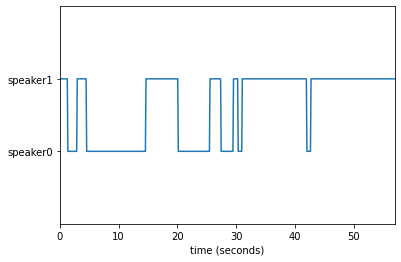

In [10]:
audio_file = ('extracted_audio/prison_stereo.wav')
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, 2, mid_window=.8, mid_step=0.1, short_window=0.02, lda_dim=0, plot_res=True)

In [11]:
speaker_list = []
x = 0
while x < len(clusters): 
    speaker_list.append(int(round(np.mean(clusters[x:x+10])))) # take the average of the ten samples per second
    x += 10

In [12]:
scene_df = pd.DataFrame(zip(frame_choice, faces_found, primary_chararcter_list, mouth_open_list, speaker_list), columns=['frame_file', 'number_faces', 'primary_character', 'mouth_open', 'speaker'])

In [13]:
scene_df.head(5)

,frame_file,number_faces,primary_character,mouth_open,speaker
0,766,1,A,1,1
1,767,1,A,1,0
2,768,0,0,0,0
3,769,1,A,1,1
4,770,1,B,0,0


In [24]:
print('Matches for A, 0:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['primary_character'] == 'A') & (scene_df['speaker'] == 0)].frame_file.size)
print('Matches for B, 1:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['primary_character'] == 'B') & (scene_df['speaker'] == 1)].frame_file.size)

Matches for A, 0: 9
Matches for B, 1: 4


In [26]:
print('Matches for A, 1:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['primary_character'] == 'A') & (scene_df['speaker'] == 1)].frame_file.size)
print('Matches for B, 0:', scene_df.loc[(scene_df['mouth_open'] == 1) & (scene_df['primary_character'] == 'B') & (scene_df['speaker'] == 0)].frame_file.size)

Matches for A, 1: 4
Matches for B, 0: 3


In [4]:
def get_lip_height(lip):
    for i in [2,3,4]:
        sum = 0
        distance = math.sqrt( (lip[i][0] - lip[12-i][0])**2 +
                              (lip[i][1] - lip[12-i][1])**2   )
        sum += distance
    return sum / 3


def get_mouth_height(top_lip, bottom_lip):
    for i in [8,9,10]:
        sum = 0
        distance = math.sqrt( (top_lip[i][0] - bottom_lip[18-i][0])**2 + 
                              (top_lip[i][1] - bottom_lip[18-i][1])**2   )
        sum += distance
    return sum / 3


def mouth_open_check(face_landmarks, open_ratio=.8):
    top_lip = face_landmarks['top_lip']
    bottom_lip = face_landmarks['bottom_lip']
    
    top_lip_height =    get_lip_height(top_lip)
    bottom_lip_height = get_lip_height(bottom_lip)
    mouth_height =      get_mouth_height(top_lip, bottom_lip)

    if mouth_height > min(top_lip_height, bottom_lip_height) * open_ratio:
        return 1
    else:
        return 0